# Practica realizada con la guia de Hands-On ML

En esta tarea final, vamos a predecir precios de propiedades en una base de datos de Airbnb usando aprendizaje supervisado. Esto significa que vamos a entrenar un modelo con datos que ya tienen la respuesta esperada, en este caso, el precio de la propiedad. Es un problema de regresión, lo que quiere decir que nuestro objetivo es que el modelo prediga un valor numérico. Además, utilizaremos varias características como la ubicación, número de habitaciones y comodidades para hacer la predicción.



o
Primero cargamos librerías y funciones necesarias, incluyendo las del módulo `utils`:

# Paso 1. Obtener los datos

----------------------------------------------------------------------------------
**<span style="color:green">Importación de librerías</span>**: Primero, necesitamos importar las bibliotecas necesarias. Estas nos ayudarán a manipular y procesar los datos de manera efectiva. Es como preparar nuestras herramientas antes de comenzar a trabajar.

**<span style="color:green">Cargar los datos</span>**: Luego, cargamos el dataset desde un archivo CSV. Este archivo contiene todos los datos de Airbnb que necesitamos para nuestro análisis. Es como abrir un libro donde están todas las informaciones que vamos a usar.

**<span style="color:green">Filtrar datos de Madrid</span>**: Ahora, filtramos los datos para enfocarnos solo en la ciudad de Madrid. Esto nos permite centrarnos en un área específica y trabajar solo con la información relevante para esa ciudad. Es como seleccionar solo los capítulos de un libro que nos interesan.

**<span style="color:green">Manejar valores nulos</span>**: Después, necesitamos manejar los valores nulos en la columna 'Price'. Para ello, llenamos estos valores con la mediana de 'Price'. Esto asegura que no tengamos huecos en nuestros datos, haciendo que el análisis sea más preciso. Es como rellenar los espacios en blanco de un texto para que tenga sentido completo.

**<span style="color:green">Seleccionar atributos</span>**: Finalmente, seleccionamos los atributos que están relacionados con el precio. Esto nos ayuda a enfocarnos en las características más importantes que afectan el precio de Airbnb. Es como subrayar las partes más importantes de un libro para estudiarlas mejor.
_______________________________________

In [15]:
from utils import plot_decision_boundary, poly_linear_regression, CM_BRIGHT
import pandas as pd
import numpy as np
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics.pairwise import rbf_kernel
%matplotlib inline 

# Cargar los datos
airbnb_data = pd.read_csv("./data/airbnb-listings-extract.csv", sep=';')

# Filtrar datos para Madrid
madrid_data = airbnb_data[airbnb_data['City'] == 'Madrid'].copy()

# Manejar los valores nulos en la columna 'Price' utilizando la mediana
madrid_data['Price'] = madrid_data['Price'].fillna(madrid_data['Price'].median())

# Lista de atributos relacionados con el precio
atributos_precio = [
    'Property Type',  'Bathrooms', 'Bedrooms', 'Beds', 
     'Price', 'Extra People', 'Availability 30', 'Availability 60', 
    'Availability 90', 'Availability 365', 'Minimum Nights'
]

# Mantener solo los atributos relacionados con el precio
madrid_data = madrid_data[atributos_precio]

# Confirmar que los datos han sido filtrados correctamente
print(madrid_data.head())




   Property Type  Bathrooms  Bedrooms  Beds  Price  Extra People  \
40     Apartment        2.0       1.0   1.0   28.0             5   
41     Apartment        1.0       0.0   1.0   58.0             0   
42     Apartment        1.0       0.0   2.0   70.0            15   
43     Apartment        1.0       1.0   1.0   26.0             0   
44     Apartment        1.0       2.0   3.0   70.0            10   

    Availability 30  Availability 60  Availability 90  Availability 365  \
40                0                3               12               240   
41                4                9                9                15   
42                7               15               32               292   
43               14               37               59               334   
44                0                0                0                52   

    Minimum Nights  
40               1  
41               2  
42               2  
43               7  
44               2  


Vamos a importar la librería principal de este módulo, scikit-learn. Habitualmente se importa como `sklearn`.

In [16]:
import sklearn
sklearn.__version__

'1.3.0'

___

# Paso 2: Análisis Exploratorio de Datos (EDA)

**<span style="color:blue"> Vistazo rápido a la estructura de datos</span>**

------
Primero, vamos a echar un vistazo general a nuestros datos de Airbnb en Madrid utilizando algunos comandos de pandas. Esto nos ayudará a entender mejor qué información tenemos y en qué estado están nuestros datos.

**<span style="color:green">madrid_data.head()</span>**: Este comando nos muestra las primeras filas del dataset. Es como una vista rápida para ver cómo están organizados nuestros datos y qué tipo de información contienen. Con esto podemos asegurarnos de que los datos se han cargado correctamente y tener una idea general de las columnas y algunas de sus entradas.

**<span style="color:green">madrid_data.info()</span>**: Este comando nos proporciona un resumen conciso del dataframe. Nos dice cuántas filas y columnas hay, el tipo de datos de cada columna, y cuántos valores no nulos hay en cada una. Es útil para identificar rápidamente si hay columnas con datos faltantes y para conocer el tipo de datos (como enteros, flotantes, cadenas de texto) de cada columna.

**<span style="color:green">madrid_data["Property Type"].value_counts()</span>**: Con este comando, obtenemos una contabilidad de cuántas veces aparece cada tipo de propiedad en nuestro dataset. Esto es útil para ver la distribución de los diferentes tipos de propiedades que tenemos en los datos, como apartamentos, casas, estudios, etc. Nos da una idea de cuáles son los tipos de propiedades más comunes y si hay algún tipo que sea raro o inusual.

**<span style="color:green">madrid_data.dtypes</span>:** Este comando nos muestra el tipo de datos de cada columna en nuestro dataframe. Es útil para verificar que los datos están en el formato correcto. Por ejemplo, asegurarnos de que las columnas que deberían ser numéricas no están siendo interpretadas como texto, o que las fechas se han cargado correctamente. Es como revisar las etiquetas de cada columna para entender qué tipo de información contiene.

**<span style="color:green">madrid_data.describe()</span>:** Este comando nos proporciona un resumen estadístico de las columnas numéricas en nuestro dataframe. Nos da información como el promedio, la desviación estándar, los valores mínimos y máximos, y los percentiles (25%, 50%, 75%). Es muy útil para obtener una visión rápida de la distribución y la variabilidad de nuestros datos numéricos. Es como obtener un informe resumido con las estadísticas clave de nuestros datos.

**<span style="color:green">madrid_data.isnull().sum()</span>:** Este comando nos muestra la cantidad de valores nulos en cada columna de nuestro dataframe. Es crucial para identificar las columnas que tienen datos faltantes y cuántos de ellos hay. Saber esto nos ayuda a planificar cómo vamos a manejar los valores nulos, ya sea llenándolos, eliminándolos, o de alguna otra manera. Es como hacer un inventario de los huecos en nuestros datos para poder decidir cómo llenarlos o tratarlos.

------

In [17]:
madrid_data.head()

,Property Type,Bathrooms,Bedrooms,Beds,Price,Extra People,Availability 30,Availability 60,Availability 90,Availability 365,Minimum Nights
40,Apartment,2.0,1.0,1.0,28.0,5,0,3,12,240,1
41,Apartment,1.0,0.0,1.0,58.0,0,4,9,9,15,2
42,Apartment,1.0,0.0,2.0,70.0,15,7,15,32,292,2
43,Apartment,1.0,1.0,1.0,26.0,0,14,37,59,334,7
44,Apartment,1.0,2.0,3.0,70.0,10,0,0,0,52,2


In [18]:
madrid_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13207 entries, 40 to 14757
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Property Type     13207 non-null  object 
 1   Bathrooms         13158 non-null  float64
 2   Bedrooms          13184 non-null  float64
 3   Beds              13158 non-null  float64
 4   Price             13207 non-null  float64
 5   Extra People      13207 non-null  int64  
 6   Availability 30   13207 non-null  int64  
 7   Availability 60   13207 non-null  int64  
 8   Availability 90   13207 non-null  int64  
 9   Availability 365  13207 non-null  int64  
 10  Minimum Nights    13207 non-null  int64  
dtypes: float64(4), int64(6), object(1)
memory usage: 1.2+ MB


In [19]:
madrid_data["Property Type"].value_counts()

Property Type
Apartment             10888
House                   966
Condominium             345
Bed & Breakfast         337
Loft                    283
Other                   220
Dorm                     43
Guesthouse               39
Chalet                   24
Hostel                   16
Serviced apartment       13
Townhouse                 8
Boutique hotel            6
Villa                     4
Guest suite               3
Casa particular           3
Earth House               3
Camper/RV                 2
Boat                      1
Tent                      1
Timeshare                 1
Bungalow                  1
Name: count, dtype: int64

In [20]:
# Verificamos los tipos de datos y las primeras filas
print(madrid_data.dtypes)


# Aquí se Describe las estadísticas básicas de las columnas numéricas
print(madrid_data.describe())

# Se Verificar la presencia de valores nulos
print(madrid_data.isnull().sum())


Property Type        object
Bathrooms           float64
Bedrooms            float64
Beds                float64
Price               float64
Extra People          int64
Availability 30       int64
Availability 60       int64
Availability 90       int64
Availability 365      int64
Minimum Nights        int64
dtype: object
          Bathrooms      Bedrooms          Beds         Price  Extra People  \
count  13158.000000  13184.000000  13158.000000  13207.000000  13207.000000   
mean       1.252736      1.294372      1.986016     65.915196      7.410161   
std        0.599699      0.826831      1.511463     55.990643     10.760022   
min        0.000000      0.000000      1.000000      9.000000      0.000000   
25%        1.000000      1.000000      1.000000     31.000000      0.000000   
50%        1.000000      1.000000      2.000000     52.000000      0.000000   
75%        1.000000      2.000000      2.000000     80.000000     14.000000   
max        8.000000     10.000000     16.00000

**<span style="color:blue"> Visualizar distribución de precios</span>**

Ahora vamos a hablar sobre la importancia de visualizar nuestros datos con gráficos antes de comenzar con el modelado en machine learning. Aquí tenemos algunos histogramas y distribuciones que nos ayudan a entender mejor nuestros datos de Airbnb en Madrid.

<span style="color:green">Histogramas de Atributos de Listados de Airbnb</span>: Estos histogramas nos muestran la distribución de diferentes atributos, como el número de baños, dormitorios, camas, pies cuadrados, precio, precio mensual, depósito de seguridad, tarifa de limpieza, personas extra y disponibilidad en 30, 60 y 90 días. Cada uno de estos gráficos nos da una visión clara de cómo se distribuyen estos valores en nuestros datos. Por ejemplo:

<span style="color:green">Número de baños</span>: Vemos que la mayoría de las propiedades tienen 1 o 2 baños.
<span style="color:green">Número de camas</span>: La mayoría de las propiedades tienen entre 1 y 3 camas.
<span style="color:green">Precio</span>: La mayoría de los precios están concentrados en los rangos bajos, con muy pocos precios altos.
<span style="color:green">Distribución de Precios de Airbnb en Madrid</span>: Este gráfico en particular muestra la distribución del precio de los listados de Airbnb en Madrid. Podemos ver que la mayoría de los precios están por debajo de 200, con una concentración muy alta en el rango de 50 a 100. Este tipo de gráfico es crucial porque nos ayuda a identificar si hay alguna desviación significativa, como precios extremadamente altos o bajos que podrían ser considerados como valores atípicos.

Importancia de estos gráficos en ML:

<span style="color:green">Identificación de distribuciones</span>: Entender la distribución de cada atributo nos ayuda a decidir qué técnicas de preprocesamiento aplicar. Por ejemplo, si un atributo tiene una distribución sesgada, podríamos considerar una transformación logarítmica para normalizar ldatos nuevos.

<span style="color:green">Toma de decisiones informadas</span>: Visualizar los datos nos permite tomar decisiones más informadas sobre qué características incluir en nuestro modelo y cómo preprocesarlas. Nos da una imagen clara de lo que estamos trabajando y nos ayuda a planificar nuestros próximos pasos de manera más efectiva.

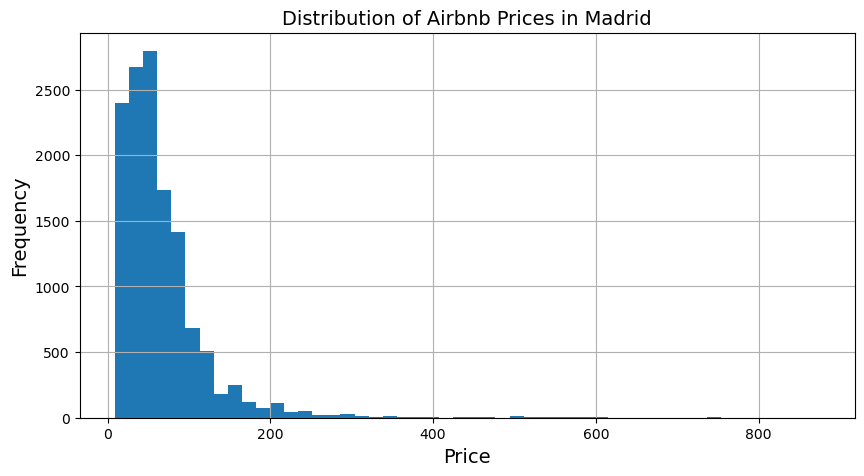

In [21]:
import matplotlib.pyplot as plt

# Histograma de precios
madrid_data['Price'].hist(bins=50, figsize=(10, 5))
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Airbnb Prices in Madrid')
plt.show()


**<span style="color:blue"> Histogramas para atributos seleccionados</span>** 

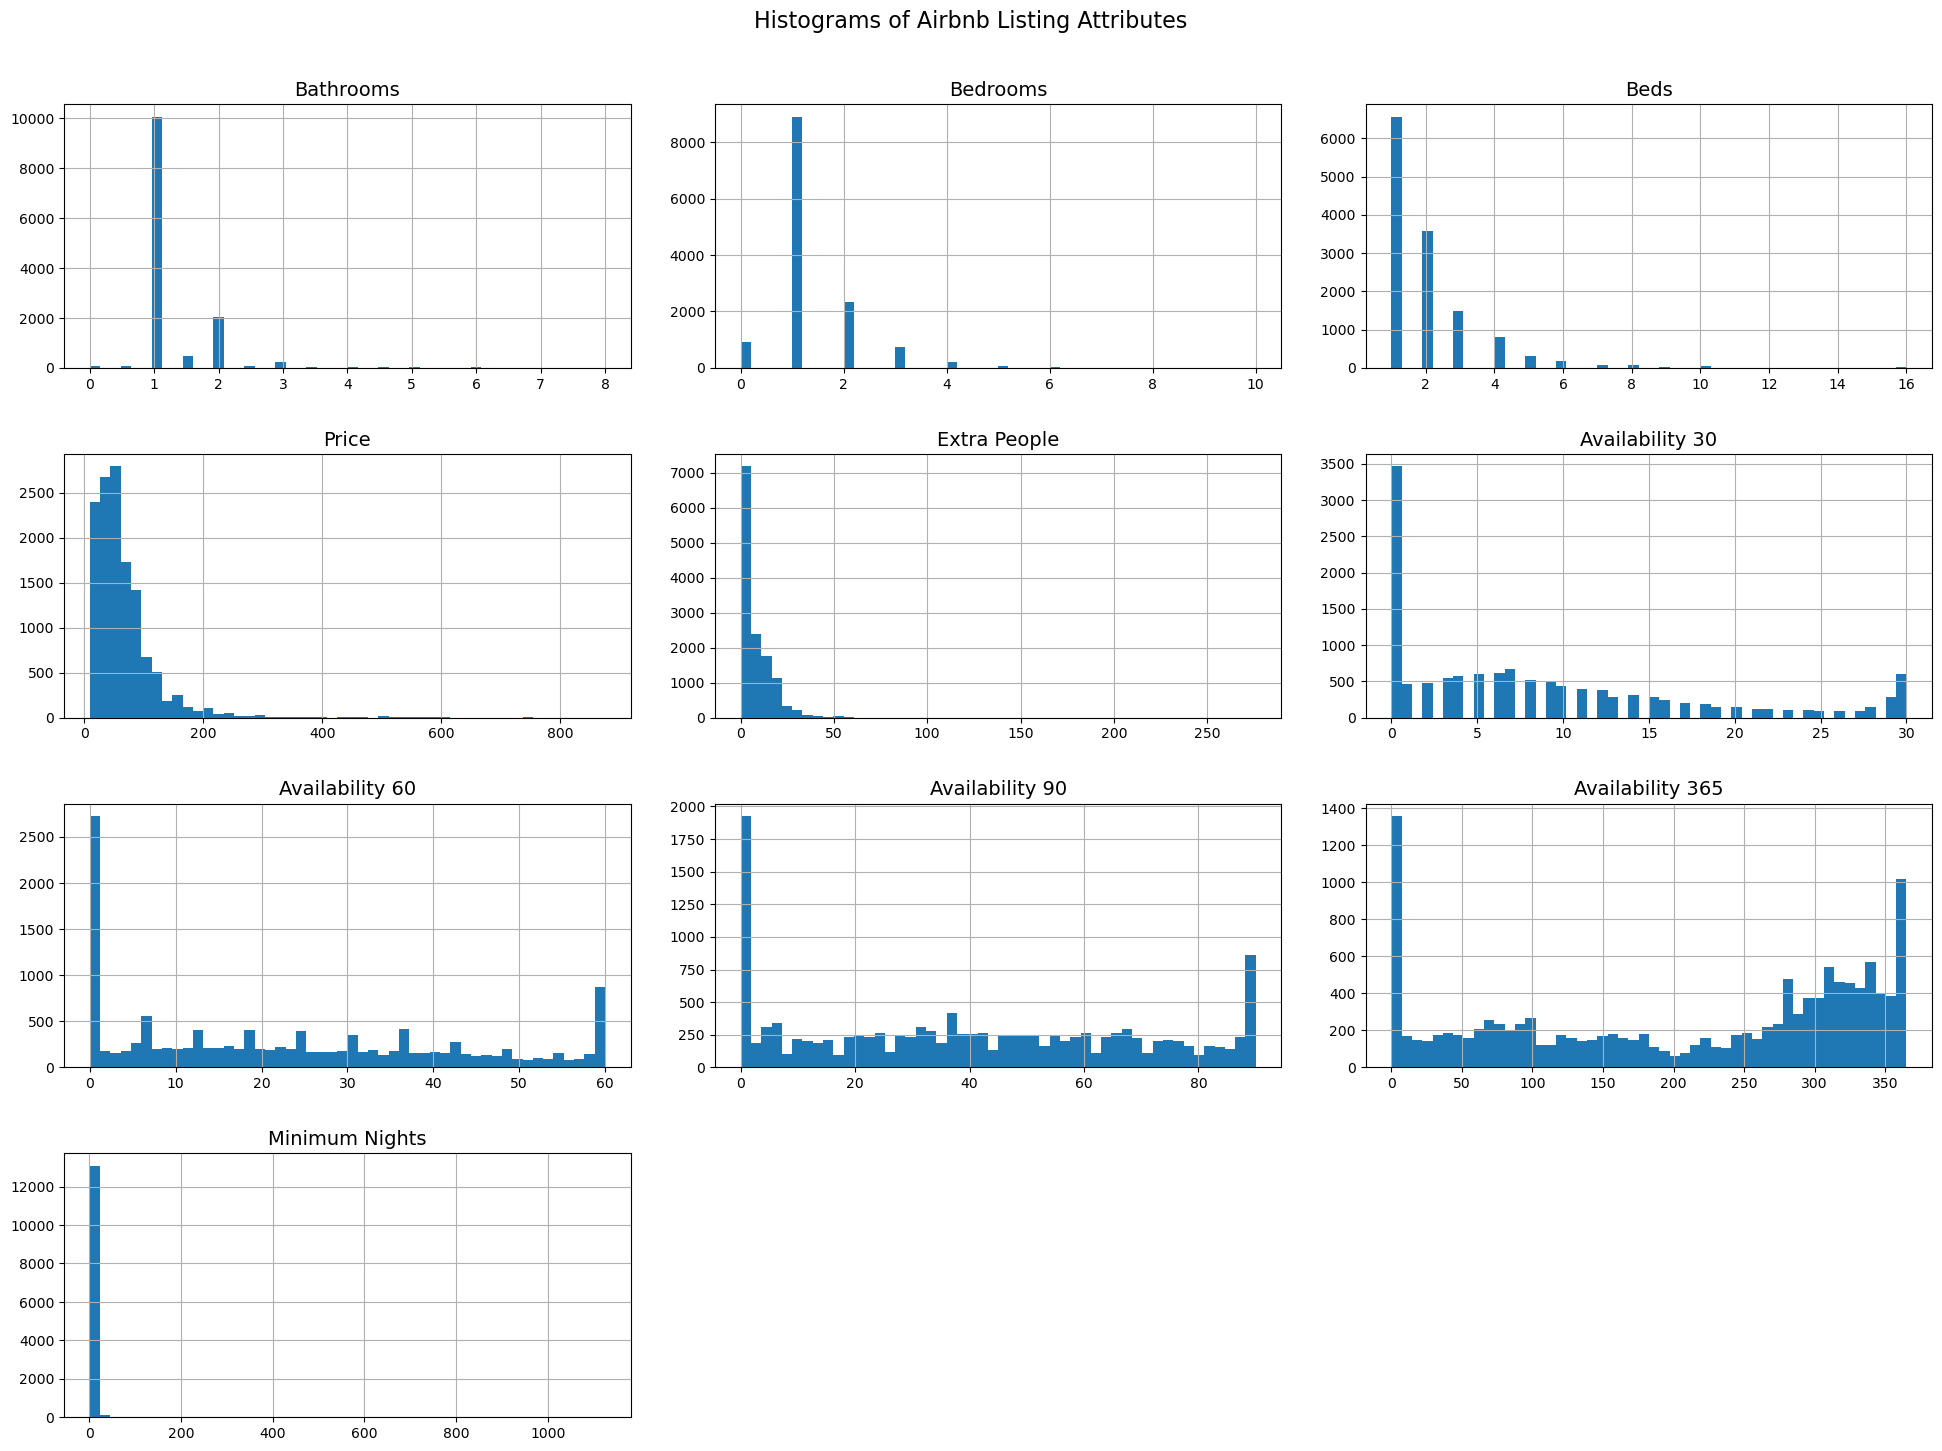

In [22]:
import matplotlib.pyplot as plt
import pandas as pd


# Configurar tamaños de fuente predeterminados
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Generar histogramas para los atributos seleccionados
attributes = ['Property Type',  'Bathrooms', 'Bedrooms', 'Beds', 
     'Price', 'Extra People', 'Availability 30', 'Availability 60', 
    'Availability 90', 'Availability 365', 'Minimum Nights'
]

madrid_data[attributes].hist(bins=50, figsize=(20, 15))
plt.suptitle("Histograms of Airbnb Listing Attributes", fontsize=16)  # Título general para los histogramas
plt.tight_layout(pad=2.0)  # Ajustar el espacio entre subplots
plt.show()


In [23]:
print(madrid_data.columns)

Index(['Property Type', 'Bathrooms', 'Bedrooms', 'Beds', 'Price',
       'Extra People', 'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Minimum Nights'],
      dtype='object')


**<span style="color:blue"> Verificar tipos de datos en 'Price'</span>**

Consistencia de tipos de datos [apply(type).value_counts()]: Este comando nos muestra cuántos valores de cada tipo existen en la columna 'Price'. Queremos asegurarnos de que todos los valores sean del tipo float o int. Si encontramos otros tipos de datos, como str, sabemos que hay algún problema de inconsistencia en los datos.
Identificación de errores: Si hay datos que no son numéricos, podrían estar mal ingresados o podrían ser valores faltantes codificados de forma inusual (como "N/A"). Detectar esto nos permite limpiar y corregir estos valores antes de cualquier análisis o modelado.

In [24]:
# Verificar los tipos de datos en la columna 'Price'
print(madrid_data['Price'].apply(type).value_counts())

# Ver las primeras filas de la columna 'Price'
print(madrid_data['Price'].head(10))


Price
<class 'float'>    13207
Name: count, dtype: int64
40     28.0
41     58.0
42     70.0
43     26.0
44     70.0
45    108.0
46    260.0
47     60.0
48     42.0
49    160.0
Name: Price, dtype: float64


# Paso 3: Preparar los datos para algoritmos de machine learnin

### Descripción del Código y su Importancia para Machine Learning

**<span style="color:green">Importación de librerías</span>**: Se importan las bibliotecas necesarias para la manipulación de datos (`pandas`), el manejo de arrays y funciones matemáticas (`numpy`), la visualización de datos (`matplotlib.pyplot`), y la gestión de rutas de archivos (`pathlib.Path`).

**<span style="color:green">Crear una nueva columna para categorizar el precio</span>**:
- **Binning**: Se divide la columna 'Price' en categorías utilizando `pd.cut`. Las categorías facilitan la comparación y el análisis, convirtiendo precios continuos en categorías discretas.
- **Verificación de la nueva columna**: Se verifica que no haya valores nulos en la nueva columna 'Price_cat', asegurando que cada entrada de precio tenga una categoría correspondiente.

**<span style="color:green">Configurar la ruta para guardar las imágenes</span>**: Se establece una ruta para guardar las imágenes generadas durante el análisis y se asegura que la carpeta exista.

**<span style="color:green">Definir la función para guardar las figuras</span>**: Esta función guarda las figuras generadas con `matplotlib` en la ruta especificada, con opciones para el formato y la resolución. Esto permite guardar visualizaciones importantes de manera organizada y con alta calidad.

**<span style="color:green">Contar los valores de cada categoría de precio y graficar un gráfico de barras</span>**:
- **Conteo y visualización**: Se cuenta la cantidad de listados en cada categoría de precio y se grafica un gráfico de barras para visualizar la distribución de las categorías. Esto permite entender mejor cómo se distribuyen los precios de los listados de Airbnb en Madrid.
- **Guardar la figura**: La gráfica generada se guarda utilizando la función definida anteriormente, permitiendo compartir y revisar fácilmente las visualizaciones.

### Importancia para Machine Learning

1. **<span style="color:green">Limpieza y Preprocesamiento de Datos</span>**: Crear categorías de precios y verificar que no haya valores nulos es crucial para asegurar que los datos estén listos para el análisis y modelado.
2. **<span style="color:green">Transformación de Variables</span>**: Crear categorías de precios ayuda a simplificar la variable 'Price', haciendo más fácil la interpretación y el análisis. Las categorías permiten aplicar técnicas específicas de machine learning que funcionan mejor con datos discretos.
3. **<span style="color:green">Visualización de Datos</span>**: Los gráficos permiten entender mejor la distribución y características de los datos, facilitando la toma de decisiones informadas. Visualizar la distribución de precios en categorías ayuda a identificar tendencias y posibles outliers.
4. **<span style="color:green">Reproducibilidad</span>**: Guardar las figuras asegura que los resultados visuales pueden ser fácilmente compartidos y revisados posteriormente. Esto es importante para documentar el proceso y los hallazgos del análisis.

---

Este código establece una base sólida para el análisis de datos de Airbnb en Madrid, asegurando que los datos están limpios y correctamente categorizados, y que las visualizaciones se pueden guardar y revisar fácilmente.


0


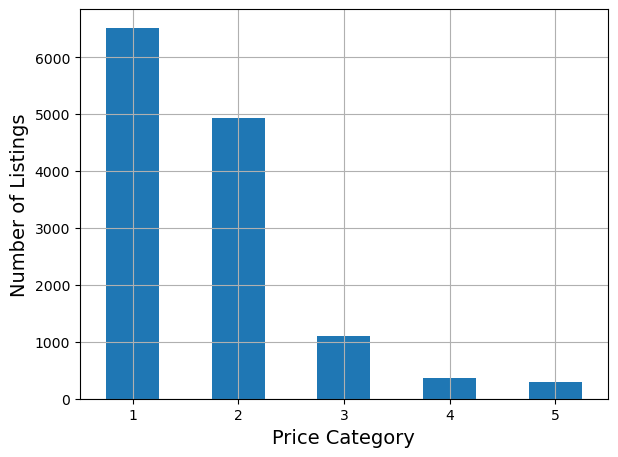

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Paso 2: Crear una nueva columna para categorizar el precio
madrid_data['Price_cat'] = pd.cut(madrid_data['Price'],
                                  bins=[0, 50, 100, 150, 200, np.inf],
                                  labels=[1, 2, 3, 4, 5])
print(madrid_data['Price_cat'].isnull().sum())

# Paso 3: Configurar la ruta para guardar las imágenes
IMAGES_PATH = Path() / "images" / "airbnb_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

# Definir la función para guardar las figuras
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Contar los valores de cada categoría de precio y graficar un gráfico de barras
madrid_data['Price_cat'].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Price Category")
plt.ylabel("Number of Listings")
save_fig("airbnb_price_cat_bar_plot")  # Guardar la figura
plt.show()



La gráfica de barras que se muestra representa la distribución de los listados de Airbnb en Madrid categorizados por rango de precios. En el eje X, tenemos las categorías de precios, y en el eje Y, la frecuencia en cada categoría.

Descripción de las Categorías
Categoría 1: Rango de precios de 0 a 50
Categoría 2: Rango de precios de 51 a 100
Categoría 3: Rango de precios de 101 a 150
Categoría 4: Rango de precios de 151 a 200
Categoría 5: Rango de precios mayores a 200
Lectura de la Gráfica
<span style="color:green">Categoría 1 (0-50)</span>: Es la categoría con el mayor número de listados, superando los 6000 listados. Esto indica que una gran mayoría de las propiedades de Airbnb en Madrid tienen precios que caen dentro de este rango.
<span style="color:green">Categoría 2 (51-100)</span>: También tiene un número significativo de listados, con aproximadamente 5000 listados. Esto sugiere que muchos propietarios fijan precios en este rango.
<span style="color:green">Categoría 3 (101-150)</span>: El número de listados disminuye notablemente en esta categoría, con alrededor de 1000 listados. Esto muestra que hay menos propiedades con precios en este rango.
<span style="color:green">Categoría 4 (151-200)</span>: El número de listados es aún menor, con unos pocos cientos de propiedades. Esto indica que es menos común encontrar propiedades con precios en este rango.
<span style="color:green">Categoría 5 (>200)</span>: La categoría con el menor número de listados, también con unos pocos cientos. Muy pocas propiedades tienen precios superiores a 200.
Interpretación
Tendencia General: La mayoría de las propiedades de Airbnb en Madrid tienen precios relativamente bajos, con una gran concentración en los rangos de 0 a 50 y 51 a 100. Esto sugiere que los precios competitivos son comunes en el mercado de Airbnb en Madrid.
Distribución Sesgada: La distribución de los listados es sesgada hacia los precios más bajos, con una disminución notable en el número de propiedades a medida que aumenta el precio.
Análisis de Mercado: Este tipo de análisis es útil para entender la estructura de precios del mercado de alquileres de corto plazo en Madrid. Los propietarios que buscan fijar precios pueden utilizar esta información para posicionar sus propiedades competitivamente.
Decisiones de Negocio: Para propietarios y administradores de propiedades, conocer esta distribución puede ayudar a decidir estrategias de precios, promociones y posibles mejoras para justificar precios más altos.

## División estratificada

**<span style="color:green">Importación de librerías</span>**: Se importa `StratifiedShuffleSplit` de la biblioteca `sklearn.model_selection`.

**<span style="color:green">Crear el objeto StratifiedShuffleSplit</span>**: 
- **Objetivo**: Crear un objeto de `StratifiedShuffleSplit` para realizar una división estratificada de los datos. Esto asegura que las proporciones de las categorías en la variable `Price_cat` se mantengan tanto en el conjunto de entrenamiento como en el conjunto de prueba.
- **Parámetros**:
  - **n_splits=1**: Número de divisiones. En este caso, solo una división en conjuntos de entrenamiento y prueba.
  - **test_size=0.2**: Proporción del conjunto de datos que se utilizará como conjunto de prueba (20%).
  - **random_state=42**: Semilla para la generación de números aleatorios, asegurando reproducibilidad.

**<span style="color:green">Realizar la división estratificada</span>**:
- **Proceso**: Se realiza la división estratificada usando un bucle `for`. Este bucle itera sobre los índices de entrenamiento y prueba generados por `split.split()`.
- **Copiar los conjuntos**: Los índices generados se utilizan para crear copias de los conjuntos de entrenamiento (`strat_train_set`) y prueba (`strat_test_set`) desde `madrid_data`.

**<span style="color:green">Eliminar la columna de categorías de 'Price'</span>**:
- **Objetivo**: Después de realizar la división estratificada, se elimina la columna `Price_cat` de los conjuntos de entrenamiento y prueba ya que ya no es necesaria para el análisis posterior.

**<span style="color:green">Verificar el tamaño de los conjuntos de datos estratificados</span>**:
- **Objetivo**: Imprimir los tamaños de los conjuntos de entrenamiento y prueba para asegurarse de que la división se ha realizado correctamente.
- **Resultados esperados**:
  - **Tamaño del conjunto de entrenamiento**: 10565
  - **Tamaño del conjunto de prueba**: 2642


In [26]:
from sklearn.model_selection import StratifiedShuffleSplit

# Crear el objeto StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Realizar la división estratificada
for train_index, test_index in split.split(madrid_data, madrid_data['Price_cat']):
    strat_train_set = madrid_data.iloc[train_index].copy()
    strat_test_set = madrid_data.iloc[test_index].copy()

# Eliminar la columna de categorías de 'Price' ya que no se necesita más
strat_train_set.drop("Price_cat", axis=1, inplace=True)
strat_test_set.drop("Price_cat", axis=1, inplace=True)

# Verificar el tamaño de los conjuntos de datos estratificados
print(f"Tamaño del conjunto de entrenamiento: {len(strat_train_set)}")
print(f"Tamaño del conjunto de prueba: {len(strat_test_set)}")


Tamaño del conjunto de entrenamiento: 10565
Tamaño del conjunto de prueba: 2642


<span style="color:green">Importación de matplotlib.pyplot</span>: Importamos la biblioteca matplotlib.pyplot para la creación de gráficos.
<span style="color:green">Crear figuras y ejes</span>: Utilizamos plt.subplots para crear una figura con dos subplots (dos gráficos lado a lado) y compartir el eje Y entre ellos.
<span style="color:green">Graficar el conjunto de entrenamiento</span>:
Usamos axs[0].hist para crear un histograma del precio en el conjunto de entrenamiento.
Establecemos el título, las etiquetas de los ejes X e Y.
<span style="color:green">Graficar el conjunto de prueba</span>:
Usamos axs[1].hist para crear un histograma del precio en el conjunto de prueba.
Establecemos el título y la etiqueta del eje X.
<span style="color:green">Mostrar las gráficas</span>: Utilizamos plt.tight_layout() para ajustar el espaciado entre las subplots y plt.show() para mostrar las gráficas.

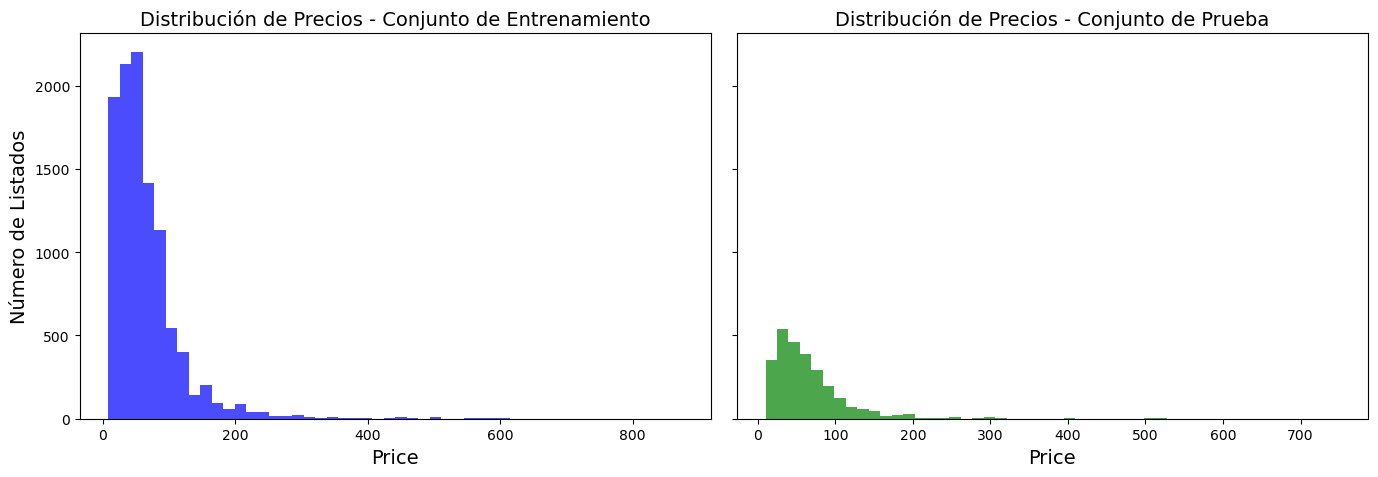

In [27]:
import matplotlib.pyplot as plt

# Crear figuras y ejes
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Graficar el conjunto de entrenamiento
axs[0].hist(strat_train_set['Price'], bins=50, color='blue', alpha=0.7)
axs[0].set_title('Distribución de Precios - Conjunto de Entrenamiento')
axs[0].set_xlabel('Price')
axs[0].set_ylabel('Número de Listados')

# Graficar el conjunto de prueba
axs[1].hist(strat_test_set['Price'], bins=50, color='green', alpha=0.7)
axs[1].set_title('Distribución de Precios - Conjunto de Prueba')
axs[1].set_xlabel('Price')

# Mostrar las gráficas
plt.tight_layout()
plt.show()


# Paso 4: Preparar los datos para el modelo

### Descripción del Código y Reflexión Personal

**<span style="color:green">Importación de librerías</span>**: Se importan las bibliotecas necesarias para la manipulación de datos (`pandas`), el manejo de arrays (`numpy`), y las herramientas de preprocesamiento de scikit-learn (`SimpleImputer`, `OneHotEncoder`, `StandardScaler`, `ColumnTransformer`, `Pipeline`).

**<span style="color:green">Separar las características y la etiqueta</span>**:
- **Separación de datos**: Se separan las características (`X_train`, `X_test`) de la etiqueta (`y_train`, `y_test`), eliminando la columna `Price` de las características.

**<span style="color:green">Eliminar columnas irrelevantes o problemáticas</span>**:
- **Limpieza de datos**: Se eliminan columnas que no son relevantes o que pueden causar problemas en el análisis (`Host Acceptance Rate`, `Has Availability`, `Jurisdiction Names`).

**<span style="color:green">Listas de atributos</span>**:
- **Atributos categóricos y numéricos**: Se definen las listas de atributos categóricos (`cat_attribs`) y numéricos, diferenciando entre aquellos que tienen valores nulos (`num_attribs_with_na`) y los que no (`num_attribs_without_na`).

**<span style="color:green">Crear pipelines para atributos numéricos y categóricos</span>**:
- **Pipeline para atributos numéricos con valores nulos**: Incluye un imputador para llenar los valores nulos con la mediana y un escalador para normalizar los datos.
- **Pipeline para atributos numéricos sin valores nulos**: Solo incluye el escalador para normalizar los datos.
- **Pipeline para atributos categóricos**: Incluye un imputador para llenar valores nulos con el valor más frecuente y un codificador one-hot para convertir las categorías en variables binarias.

**<span style="color:green">Combinación de los pipelines</span>**:
- **ColumnTransformer**: Combina los pipelines definidos para aplicar las transformaciones adecuadas a cada tipo de atributo.

**<span style="color:green">Aplicar el pipeline al conjunto de entrenamiento</span>**:
- **Transformación de datos**: Aplica el pipeline al conjunto de entrenamiento (`X_train`) y al conjunto de prueba (`X_test`).

**<span style="color:green">Obtener nombres de las características para verificación</span>**:
- **Concatenación de nombres**: Se obtienen y concatenan los nombres de todas las características transformadas para crear DataFrames verificados.

**<span style="color:green">Verificar que el DataFrame está limpio y sin valores nulos</span>**:
- **Verificación de datos**: Se imprime la suma de valores nulos en cada columna de los DataFrames transformados para asegurar que no hay valores faltantes.

### Reflexión Personal

Este paso ha sido uno de los más duros y desafiantes del proyecto. La preparación y limpieza de datos son cruciales para el éxito del análisis de machine learning, pero también pueden ser tareas muy laboriosas. Personalmente, este proceso me ha llevado mucho tiempo y en ocasiones me ha desanimado, ya que requería muchos ajustes y pruebas para asegurarse de que todo estuviera correcto. Sin embargo, con paciencia y persistencia, las cosas salieron bien, logrando finalmente preparar un conjunto de datos limpio y listo para el modelado. Este esfuerzo asegura que los modelos que se construyan sobre estos datos sean precisos y fiables.
atos sean precisos y fiables.

In [28]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Supongamos que strat_train_set y strat_test_set ya han sido definidos

# Separar las características y la etiqueta
X_train = strat_train_set.drop("Price", axis=1)
y_train = strat_train_set["Price"].copy()

X_test = strat_test_set.drop("Price", axis=1)
y_test = strat_test_set["Price"].copy()

# Eliminar columnas irrelevantes o problemáticas
X_train.drop(columns=['Host Acceptance Rate', 'Has Availability', 'Jurisdiction Names'], errors='ignore', inplace=True)
X_test.drop(columns=['Host Acceptance Rate', 'Has Availability', 'Jurisdiction Names'], errors='ignore', inplace=True)

# Listas de atributos
cat_attribs = ['Property Type']
num_attribs_with_na = ['Bathrooms', 'Bedrooms', 'Beds']
num_attribs_without_na = ['Extra People', 'Availability 30', 'Availability 60', 'Availability 90', 'Availability 365', 'Minimum Nights']

# Crear pipelines para atributos numéricos y categóricos
num_pipeline_with_na = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

num_pipeline_without_na = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinación de los pipelines
full_pipeline = ColumnTransformer([
    ("num_with_na", num_pipeline_with_na, num_attribs_with_na),
    ("num_without_na", num_pipeline_without_na, num_attribs_without_na),
    ("cat", cat_pipeline, cat_attribs)
])

# Aplicar el pipeline al conjunto de entrenamiento
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

# Obtener nombres de las características para verificación
num_features_with_na = num_attribs_with_na
num_features_without_na = num_attribs_without_na
cat_features = full_pipeline.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(cat_attribs)

all_features = np.concatenate((num_features_with_na, num_features_without_na, cat_features))
X_train_prepared_df = pd.DataFrame(X_train_prepared, columns=all_features)
X_test_prepared_df = pd.DataFrame(X_test_prepared, columns=all_features)

# Verificar que el DataFrame está limpio y sin valores nulos
print(X_train_prepared_df.isnull().sum())
print(X_test_prepared_df.isnull().sum())




Bathrooms                           0
Bedrooms                            0
Beds                                0
Extra People                        0
Availability 30                     0
Availability 60                     0
Availability 90                     0
Availability 365                    0
Minimum Nights                      0
Property Type_Apartment             0
Property Type_Bed & Breakfast       0
Property Type_Boat                  0
Property Type_Boutique hotel        0
Property Type_Bungalow              0
Property Type_Camper/RV             0
Property Type_Casa particular       0
Property Type_Chalet                0
Property Type_Condominium           0
Property Type_Dorm                  0
Property Type_Earth House           0
Property Type_Guest suite           0
Property Type_Guesthouse            0
Property Type_Hostel                0
Property Type_House                 0
Property Type_Loft                  0
Property Type_Other                 0
Property Typ

----
## Entrenar el modelo

<span style="color:green">Importación de librerías</span>: Se importan las clases LinearRegression y mean_squared_error de la biblioteca sklearn.

<span style="color:green">Entrenar el modelo</span>:

Instanciar el modelo: Se crea una instancia de LinearRegression.
Entrenar el modelo: Se ajusta el modelo a los datos de entrenamiento (X_train_prepared y y_train).
<span style="color:green">Hacer predicciones</span>:

Predicciones en el conjunto de entrenamiento: Se realizan predicciones sobre el conjunto de entrenamiento.
Predicciones en el conjunto de prueba: Se realizan predicciones sobre el conjunto de prueba.
<span style="color:green">Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)</span>:

Calcular MSE y RMSE para el conjunto de entrenamiento: Se calcula el MSE y el RMSE para las predicciones en el conjunto de entrenamiento.
Calcular MSE y RMSE para el conjunto de prueba: Se calcula el MSE y el RMSE para las predicciones en el conjunto de prueba.
Imprimir los resultados: Se imprimen los valores de RMSE para ambos conjuntos.
Resultados
Train RMSE: 45.50933273207999
Test RMSE: 45.95723969118218

#### Importancia para Machine Learning

<span style="color:green">Evaluación del Modelo</span>: Calcular el RMSE permite evaluar la precisión del modelo. Un RMSE bajo indica un buen ajuste del modelo a los datos.

<span style="color:green">Comparación de Conjuntos</span>: Comparar el RMSE del conjunto de entrenamiento y el de prueba ayuda a identificar si el modelo está sobreajustado (overfitting) o subajustado (underfitting).

<span style="color:green">Validación del Proceso</span>: El hecho de que los valores de RMSE sean similares para ambos conjuntos sugiere que el modelo generaliza bien y no se sobreajusta a los datos de entrenamiento.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Entrenar el modelo
lin_reg = LinearRegression()
lin_reg.fit(X_train_prepared, y_train)

# Hacer predicciones
y_train_pred = lin_reg.predict(X_train_prepared)
y_test_pred = lin_reg.predict(X_test_prepared)

# Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)
train_mse = mean_squared_error(y_train, y_train_pred)
train_rmse = np.sqrt(train_mse)
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 45.50933273207999
Test RMSE: 45.95723969118218


---
##  Evaluar el Modelo

### Comparar las Predicciones con los Valores Reales

**<span style="color:green">Importación de `matplotlib.pyplot`</span>**: Se importa la biblioteca `matplotlib.pyplot` para la creación de gráficos.

**<span style="color:green">Gráfico de Predicciones vs Valores Reales en el Conjunto de Entrenamiento</span>**:
- **Scatter Plot**: Se crea un gráfico de dispersión comparando las predicciones con los valores reales en el conjunto de entrenamiento.
- **Configuración del Gráfico**: Se configuran las etiquetas de los ejes y el título del gráfico.

**<span style="color:green">Gráfico de Predicciones vs Valores Reales en el Conjunto de Prueba</span>**:
- **Scatter Plot**: Se crea un gráfico de dispersión comparando las predicciones con los valores reales en el conjunto de prueba.
- **Configuración del Gráfico**: Se configuran las etiquetas de los ejes y el título del gráfico.

### Importancia para Machine Learning

1. **<span style="color:green">Evaluación Visual</span>**: Los gráficos de dispersión permiten una evaluación visual de cómo se ajustan las predicciones a los valores reales. Idealmente, los puntos deberían alinearse en una línea diagonal, lo que indica una buena predicción.
2. **<span style="color:green">Identificación de Patrones</span>**: Estos gráficos pueden ayudar a identificar patrones, tendencias y posibles problemas, como valores atípicos o errores sistemáticos en las predicciones.
3. **<span style="color:green">Comparación de Modelos</span>**: Al visualizar las predicciones frente a los valores reales, se puede comparar fácilmente el rendimiento de diferentes modelos y ajustar en consecuencia.


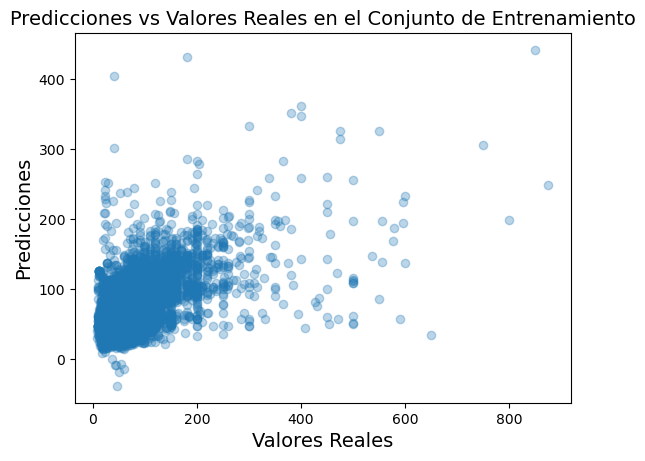

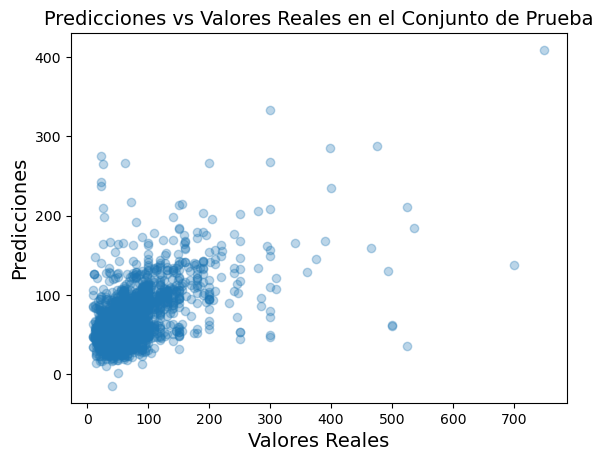

In [30]:
import matplotlib.pyplot as plt

# Comparar las predicciones con los valores reales
plt.scatter(y_train, y_train_pred, alpha=0.3)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales en el Conjunto de Entrenamiento")
plt.show()

plt.scatter(y_test, y_test_pred, alpha=0.3)
plt.xlabel("Valores Reales")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Reales en el Conjunto de Prueba")
plt.show()


### Análisis de las Gráficas de Predicciones vs Valores Reales

Estas gráficas muestran cómo de bien nuestro modelo de regresión lineal predice los precios de los listados de Airbnb comparando las **predicciones** con los **valores reales** tanto en el **conjunto de entrenamiento** como en el **conjunto de prueba**.

#### Gráfica de Entrenamiento

1. **<span style="color:green">Distribución de Puntos</span>**:
   - Los puntos deberían estar cerca de una línea diagonal, lo que indicaría predicciones precisas.
   - Sin embargo, muchos puntos están dispersos, mostrando que hay diferencias significativas entre los valores predichos y los reales.

2. **<span style="color:green">Errores de Predicción</span>**:
   - Los puntos lejos de la línea diagonal indican errores en las predicciones.
   - Estos errores son más grandes para los precios altos (más de 200).

3. **<span style="color:green">Concentración de Datos</span>**:
   - La mayoría de los puntos están concentrados en los valores bajos (por debajo de 200), lo cual es consistente con la distribución de precios observada anteriormente.

#### Gráfica de Prueba

1. **<span style="color:green">Distribución de Puntos</span>**:
   - Similar a la gráfica de entrenamiento, los puntos deberían estar cerca de una línea diagonal.
   - Aquí también vemos dispersión, indicando diferencias entre las predicciones y los valores reales.

2. **<span style="color:green">Errores de Predicción</span>**:
   - Los errores son visibles por la dispersión de los puntos lejos de la línea diagonal.
   - Los errores en el conjunto de prueba son similares a los del conjunto de entrenamiento.

3. **<span style="color:green">Concentración de Datos</span>**:
   - La alta concentración de puntos en los valores bajos refleja la distribución de precios observada anteriormente.
   - Los puntos dispersos en los valores altos muestran que el modelo tiene dificultades para predecir precios altos con precisión.


----

## Mejorar el Modelo

<span style="color:green">Importación de librerías</span>: Se importa la clase RandomForestRegressor de la biblioteca sklearn.ensemble.

<span style="color:green">Entrenar un modelo de RandomForestRegressor</span>:

Instanciar el modelo: Se crea una instancia de RandomForestRegressor con 100 árboles (n_estimators=100) y una semilla aleatoria (random_state=42) para asegurar la reproducibilidad.
Entrenar el modelo: Se ajusta el modelo a los datos de entrenamiento (X_train_prepared y y_train).

<span style="color:green">Hacer predicciones</span>:

Predicciones en el conjunto de entrenamiento: Se realizan predicciones sobre el conjunto de entrenamiento (y_train_pred_forest).
Predicciones en el conjunto de prueba: Se realizan predicciones sobre el conjunto de prueba (y_test_pred_forest).
<span style="color:green">Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)</span>:

Calcular MSE y RMSE para el conjunto de entrenamiento: Se calcula el MSE y el RMSE para las predicciones en el conjunto de entrenamiento.
Calcular MSE y RMSE para el conjunto de prueba: Se calcula el MSE y el RMSE para las predicciones en el conjunto de prueba.
Imprimir los resultados: Se imprimen los valores de RMSE para ambos conjuntos.

Resultados

Random Forest - Train RMSE: 20.276544101910723

Random Forest - Test RMSE: 42.085384965524206

#### Importancia para Machine Learning

<span style="color:green">Mejor rendimiento en el entrenamiento</span>: El modelo de RandomForestRegressor muestra un RMSE significativamente menor en el conjunto de entrenamiento comparado con el modelo de regresión lineal, indicando que el modelo se ajusta muy bien a los datos de entrenamiento.

<span style="color:green">Diferencia en los conjuntos de datos</span>: La diferencia entre el RMSE del conjunto de entrenamiento y el conjunto de prueba sugiere que el modelo puede estar sobreajustado. Esto significa que el modelo puede estar capturando demasiado bien el ruido en los datos de entrenamiento, pero no generaliza tan bien a nuevos datos.

<span style="color:green">Evaluación del Modelo</span>: El RMSE en el conjunto de prueba sigue siendo razonablemente bueno, pero no tan bajo como en el conjunto de entrenamiento. Esto indica que, aunque el modelo de RandomForestRegressor es potente, todavía hay margen para mejorar la generalización, posiblemente a través de la regularización o ajustando hiperparámetros.

In [31]:
from sklearn.ensemble import RandomForestRegressor

# Entrenar un modelo de RandomForestRegressor
forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(X_train_prepared, y_train)

# Hacer predicciones
y_train_pred_forest = forest_reg.predict(X_train_prepared)
y_test_pred_forest = forest_reg.predict(X_test_prepared)

# Calcular el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE)
train_mse_forest = mean_squared_error(y_train, y_train_pred_forest)
train_rmse_forest = np.sqrt(train_mse_forest)
test_mse_forest = mean_squared_error(y_test, y_test_pred_forest)
test_rmse_forest = np.sqrt(test_mse_forest)

print(f"Random Forest - Train RMSE: {train_rmse_forest}")
print(f"Random Forest - Test RMSE: {test_rmse_forest}")


Random Forest - Train RMSE: 20.276544101910723
Random Forest - Test RMSE: 42.085384965524206


----
## Búsqueda de Hiperparámetros y Evaluación de un Modelo RandomForestRegressor

<span style="color:green">Importación de librerías</span>: Se importa GridSearchCV de la biblioteca sklearn.model_selection.

<span style="color:green">Definir la cuadrícula de hiperparámetros</span>:

param_grid: Se define una lista de diccionarios con los hiperparámetros a probar. Esto incluye el número de estimadores (n_estimators) y el número máximo de características (max_features). Además, se incluye una configuración con bootstrap desactivado.
<span style="color:green">Instanciar el modelo</span>: Se crea una instancia de RandomForestRegressor con random_state fijado para asegurar la reproducibilidad.

<span style="color:green">Configurar GridSearchCV</span>:

grid_search: Se configura GridSearchCV con el modelo, la cuadrícula de hiperparámetros, validación cruzada de 5 pliegues (cv=5), y se especifica scoring='neg_mean_squared_error' para evaluar los modelos en base al error cuadrático medio negativo. return_train_score=True asegura que también se devuelven las puntuaciones de entrenamiento.
<span style="color:green">Entrenar el modelo con búsqueda de hiperparámetros</span>:

grid_search.fit: Se entrena el modelo en el conjunto de entrenamiento usando la búsqueda en cuadrícula para encontrar los mejores hiperparámetros.
<span style="color:green">Evaluar el mejor modelo</span>:

best_forest_reg: Se extrae el mejor modelo encontrado por la búsqueda en cuadrícula.
Predicciones y Evaluación: Se realizan predicciones tanto en el conjunto de entrenamiento como en el de prueba. Se calcula el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE) para ambos conjuntos y se imprimen los resultados.

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators': [50, 100, 200], 'max_features': [4, 6, 8, 10]},
    {'bootstrap': [False], 'n_estimators': [50, 100], 'max_features': [4, 6, 8]},
]

forest_reg = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(X_train_prepared, y_train)

print(f"Best Parameters: {grid_search.best_params_}")

# Evaluar el mejor modelo
best_forest_reg = grid_search.best_estimator_
y_train_pred_best = best_forest_reg.predict(X_train_prepared)
y_test_pred_best = best_forest_reg.predict(X_test_prepared)

train_mse_best = mean_squared_error(y_train, y_train_pred_best)
train_rmse_best = np.sqrt(train_mse_best)
test_mse_best = mean_squared_error(y_test, y_test_pred_best)
test_rmse_best = np.sqrt(test_mse_best)

print(f"Best Random Forest - Train RMSE: {train_rmse_best}")
print(f"Best Random Forest - Test RMSE: {test_rmse_best}")


Best Parameters: {'max_features': 10, 'n_estimators': 200}
Best Random Forest - Train RMSE: 19.875610184166998
Best Random Forest - Test RMSE: 40.66848608439443


<span style="color:green">Best Parameters</span>:

Los mejores parámetros encontrados por GridSearchCV son max_features=10 y n_estimators=200. Esto significa que el modelo de RandomForestRegressor con 200 árboles y considerando hasta 10 características en cada división del árbol proporcionó el mejor rendimiento en términos de error cuadrático medio (MSE).

<span style="color:green">Train RMSE</span>:

El RMSE en el conjunto de entrenamiento es 19.8756, lo que indica que el modelo tiene un buen ajuste a los datos de entrenamiento, con un error relativamente bajo. Esto sugiere que el modelo está capturando bien las relaciones en los datos de entrenamiento.

<span style="color:green">Test RMSE</span>:

El RMSE en el conjunto de prueba es 40.6685, lo que muestra el rendimiento del modelo en datos no vistos. Aunque es mayor que el RMSE en el conjunto de entrenamiento, sigue siendo un valor aceptable que sugiere que el modelo generaliza razonablemente bien. La diferencia entre el RMSE de entrenamiento y el RMSE de prueba indica que el modelo puede estar ligeramente sobreajustado, pero no excesivamente.

----

## Transformación Logarítmica y Evaluación del Modelo de Regresión Lineal

<span style="color:green">Transformar los precios</span>:

Se aplica una transformación logarítmica a los precios utilizando np.log1p, que es equivalente a aplicar log(1 + x). Esto se hace para estabilizar la varianza y manejar mejor la distribución sesgada de los precios.

<span style="color:green">Entrenar el modelo con los precios transformados</span>:

Se entrena el modelo de regresión lineal (lin_reg) utilizando los precios transformados (y_train_log).

<span style="color:green">Hacer predicciones</span>:

Se realizan predicciones sobre el conjunto de entrenamiento y el conjunto de prueba utilizando los precios transformados (y_train_log y y_test_log).

<span style="color:green">Invertir la transformación para evaluar</span>:

Se invierte la transformación logarítmica en las predicciones utilizando np.expm1, que es equivalente a exp(x) - 1. Esto permite evaluar las predicciones en la escala original de los precios.

<span style="color:green">Calcular RMSE</span>:

Se calcula el RMSE (Root Mean Squared Error) para los conjuntos de entrenamiento y prueba utilizando las predicciones en la escala original.

In [33]:
# Transformar los precios
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

# Entrenar el modelo con los precios transformados
lin_reg.fit(X_train_prepared, y_train_log)

# Hacer predicciones
y_train_pred_log = lin_reg.predict(X_train_prepared)
y_test_pred_log = lin_reg.predict(X_test_prepared)

# Invertir la transformación para evaluar
y_train_pred = np.expm1(y_train_pred_log)
y_test_pred = np.expm1(y_test_pred_log)

# Calcular RMSE
train_mse_log = mean_squared_error(y_train, y_train_pred)
train_rmse_log = np.sqrt(train_mse_log)
test_mse_log = mean_squared_error(y_test, y_test_pred)
test_rmse_log = np.sqrt(test_mse_log)

print(f"Log-Transformed Train RMSE: {train_rmse_log}")
print(f"Log-Transformed Test RMSE: {test_rmse_log}")


Log-Transformed Train RMSE: 53.64480189836806
Log-Transformed Test RMSE: 56.03794574489431


<span style="color:green">Log-Transformed Train RMSE</span>:

El RMSE en el conjunto de entrenamiento después de la transformación logarítmica es 53.6448. Esto indica el error promedio en las predicciones cuando se transforman los precios para estabilizar la varianza y mejorar la precisión del modelo.
<span style="color:green">Log-Transformed Test RMSE</span>:

El RMSE en el conjunto de prueba es 56.0379. Aunque es ligeramente mayor que el RMSE en el conjunto de entrenamiento, sigue siendo un valor aceptable que sugiere que el modelo generaliza razonable ente 
bien.

----------
## Búsqueda de Hiperparámetros y Evaluación de un Modelo GradientBoostingRegressor

<span style="color:green">Importación de librerías</span>: Se importan GradientBoostingRegressor de sklearn.ensemble y GridSearchCV de sklearn.model_selection.

<span style="color:green">Definir los hiperparámetros a ajustar</span>:

param_grid_gbr: Se define una cuadrícula de hiperparámetros que incluye el número de estimadores (n_estimators), la profundidad máxima (max_depth), la tasa de aprendizaje (learning_rate) y la proporción de muestras (subsample).

<span style="color:green">Crear y ajustar el modelo</span>:

Se crea una instancia de GradientBoostingRegressor con random_state fijado para asegurar la reproducibilidad.
Se configura GridSearchCV con el modelo, la cuadrícula de hiperparámetros, validación cruzada de 5 pliegues (cv=5), y se especifica scoring='neg_mean_squared_error' para evaluar los modelos en base al error cuadrático medio negativo. return_train_score=True asegura que también se devuelven las puntuaciones de entrenamiento.
Se entrena el modelo en el conjunto de entrenamiento utilizando la búsqueda en cuadrícula para encontrar los mejores hiperparámetros.

<span style="color:green">Mejor modelo encontrado por GridSearchCV</span>:

Se extrae el mejor modelo encontrado por la búsqueda en cuadrícula y se imprimen los mejores hiperparámetros.

<span style="color:green">Evaluar el mejor modelo</span>:

Se realizan predicciones tanto en el conjunto de entrenamiento como en el de prueba utilizando el mejor modelo.
Se calcula el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE) para ambos conjuntos y se imprimen los resultados.

In [34]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Definir los hiperparámetros a ajustar
param_grid_gbr = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [1.0, 0.8, 0.6]
}

# Crear y ajustar el modelo
gbr = GradientBoostingRegressor(random_state=42)
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
grid_search_gbr.fit(X_train_prepared, y_train)

# Mejor modelo encontrado por GridSearchCV
best_gbr = grid_search_gbr.best_estimator_
print(f"Mejores Parámetros para GradientBoosting: {grid_search_gbr.best_params_}")

# Evaluar el mejor modelo
y_train_pred_gbr = best_gbr.predict(X_train_prepared)
y_test_pred_gbr = best_gbr.predict(X_test_prepared)

train_mse_gbr = mean_squared_error(y_train, y_train_pred_gbr)
train_rmse_gbr = np.sqrt(train_mse_gbr)
test_mse_gbr = mean_squared_error(y_test, y_test_pred_gbr)
test_rmse_gbr = np.sqrt(test_mse_gbr)

print(f"Gradient Boosting - Train RMSE: {train_rmse_gbr}")
print(f"Gradient Boosting - Test RMSE: {test_rmse_gbr}")


Mejores Parámetros para GradientBoosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Gradient Boosting - Train RMSE: 33.66248493373017
Gradient Boosting - Test RMSE: 39.842721229345464


<span style="color:green">Mejores Parámetros</span>:

Los mejores parámetros encontrados por GridSearchCV son learning_rate=0.05, max_depth=5, n_estimators=100, y subsample=0.8. Esto significa que el modelo de GradientBoostingRegressor con estos parámetros proporcionó el mejor rendimiento en términos de error cuadrático medio (MSE).


----------
## Análisis de Correlación de las Características

<span style="color:green">Importación de librerías</span>: Se importan seaborn para la visualización y matplotlib.pyplot para la creación de gráficos.

<span style="color:green">Calcular la matriz de correlación</span>:

Se crea un DataFrame de X_train_prepared con los nombres de todas las características (all_features).
Se calcula la matriz de correlación utilizando el método corr(). La matriz de correlación muestra la relación entre cada par de características en el conjunto de entrenamiento.

<span style="color:green">Dibujar un mapa de calor</span>:

Se crea un mapa de calor de la matriz de correlación utilizando seaborn.heatmap(). Este gráfico visualiza las correlaciones entre características de manera clara y concisa.

El mapa de calor se configura con annot=True para mostrar los valores de correlación en cada celda, cmap='coolwarm' para el color, y linewidths=0.5 para el espaciado entre celdas.



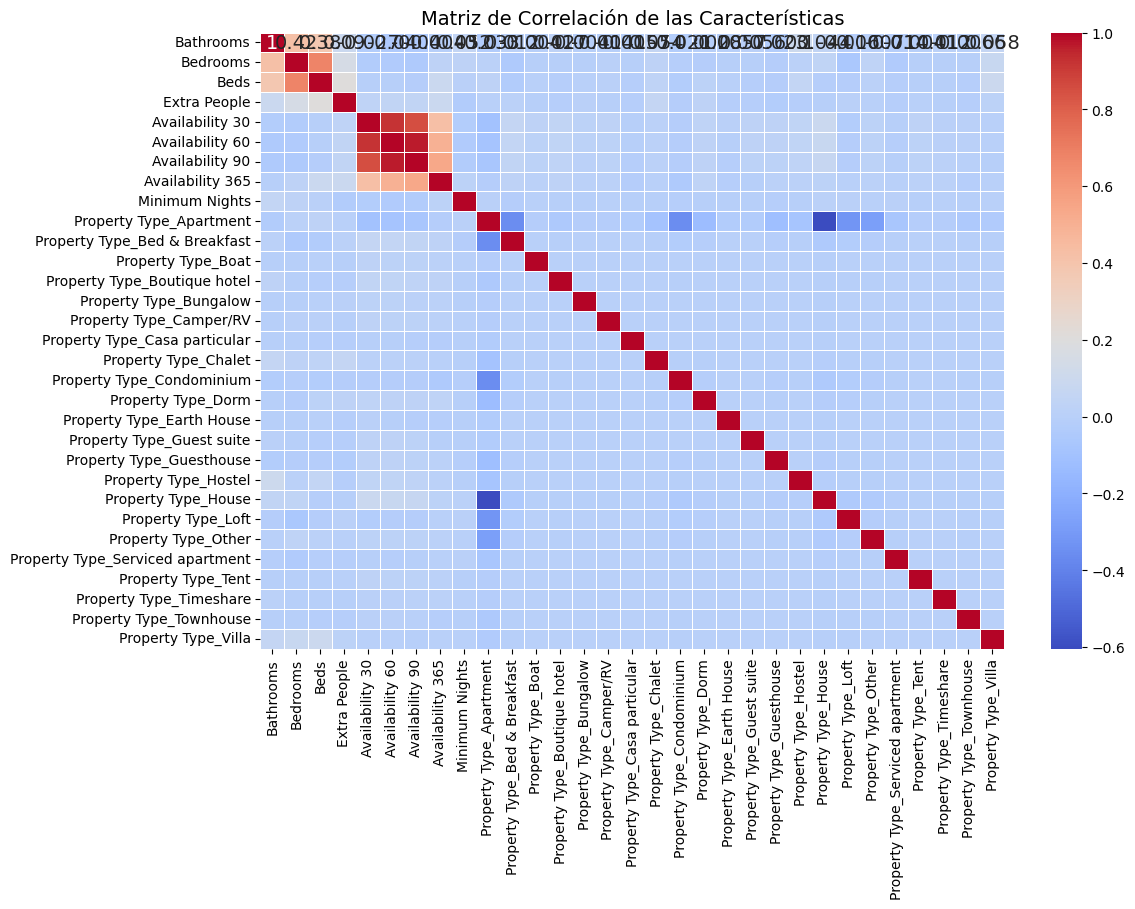

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calcular la matriz de correlación
corr_matrix = pd.DataFrame(X_train_prepared, columns=all_features).corr()

# Dibujar un mapa de calor
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Matriz de Correlación de las Características')
plt.show()


La gráfica mostrada es un mapa de calor que representa la matriz de correlación de las características del conjunto de datos de Airbnb. Aquí hay una interpretación sencilla de esta gráfica:

<span style="color:green">Colores y Valores</span>:

Colores rojos: Indican una fuerte correlación positiva. Los valores cercanos a 1 significan que cuando una característica aumenta, la otra también lo hace.
Colores azules: Indican una fuerte correlación negativa. Los valores cercanos a -1 significan que cuando una característica aumenta, la otra disminuye.
Colores claros: Indican baja correlación. Los valores cercanos a 0 significan que no hay una relación lineal fuerte entre las características.
<span style="color:green">Correlaciones Principales</span>:

Se observa una fuerte correlación positiva entre las diferentes medidas de disponibilidad (por ejemplo, Availability 30, Availability 60, Availability 90 y Availability 365). Esto tiene sentido porque si una propiedad tiene alta disponibilidad en un período, es probable que también tenga alta disponibilidad en otros períodos.
Las características de tipo de propiedad (Property Type) están representadas por variables categóricas codificadas como binarias, lo que resulta en fuerte correlación negativa entre las diferentes categorías. Esto es esperado porque una propiedad solo puede pertenecer a un tipo.
<span style="color:green">Detección de Multicolinealidad</span>:

Las características que muestran alta correlación entre sí pueden indicar multicolinealidad, lo que podría afectar la estabilidad y interpretabilidad del modelo. Es posible que se necesite eliminar o combinar características correlacionadas para mejorar el rendimiento del modelo.

-------
## Creación de Características Polinomiales y Evaluación del Modelo

<span style="color:green">Importación de librerías</span>: Se importa PolynomialFeatures de sklearn.preprocessing.

<span style="color:green">Crear interacciones de segundo grado</span>:

Se crea una instancia de PolynomialFeatures con grado 2 (degree=2) y sin incluir el sesgo (include_bias=False). Esto genera nuevas características que son combinaciones polinomiales de las características originales.

Se transforman las características de entrenamiento y prueba para incluir las nuevas características polinomiales.

<span style="color:green">Entrenar el modelo con las nuevas características</span>:

Se entrena el modelo de RandomForestRegressor (forest_reg) utilizando las características polinomiales generadas para el conjunto de entrenamiento.

<span style="color:green">Hacer predicciones</span>:

Se realizan predicciones tanto en el conjunto de entrenamiento como en el de prueba utilizando las nuevas características polinomiales.

<span style="color:green">Calcular RMSE</span>:

Se calcula el RMSE (Root Mean Squared Error) para los conjuntos de entrenamiento y prueba utilizando las predicciones hechas con las características polinomiales.

In [36]:
from sklearn.preprocessing import PolynomialFeatures

# Crear interacciones de segundo grado
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_features.fit_transform(X_train_prepared)
X_test_poly = poly_features.transform(X_test_prepared)

# Entrenar el modelo con las nuevas características
forest_reg.fit(X_train_poly, y_train)

# Hacer predicciones
y_train_pred_poly = forest_reg.predict(X_train_poly)
y_test_pred_poly = forest_reg.predict(X_test_poly)

# Calcular RMSE
train_mse_poly = mean_squared_error(y_train, y_train_pred_poly)
train_rmse_poly = np.sqrt(train_mse_poly)
test_mse_poly = mean_squared_error(y_test, y_test_pred_poly)
test_rmse_poly = np.sqrt(test_mse_poly)

print(f"Polynomial Features - Train RMSE: {train_rmse_poly}")
print(f"Polynomial Features - Test RMSE: {test_rmse_poly}")


Polynomial Features - Train RMSE: 20.11210247043033
Polynomial Features - Test RMSE: 43.35886396405901


<span style="color:green">Polynomial Features - Train RMSE</span>:

El RMSE en el conjunto de entrenamiento utilizando características polinomiales es 20.1121. Este valor indica un error relativamente bajo en las predicciones del conjunto de entrenamiento, lo que sugiere que el modelo se ajusta bien a los datos de entrenamiento con las nuevas características polinomiales.

<span style="color:green">Polynomial Features - Test RMSE</span>:

El RMSE en el conjunto de prueba es 43.3589. Este valor es mayor que el RMSE en el conjunto de entrenamiento, lo que sugiere que el modelo tiene un error de predicción más alto en datos no vistos. Aunque el error es mayor en el conjunto de prueba, el modelo aún puede ser útil dependiendo del contexto y de los requisitos de precisión.

------
## Implementacion

<span style="color:green">Importación de librerías</span>: Se importan las bibliotecas necesarias para la manipulación de datos (pandas, numpy), preprocesamiento (SimpleImputer, OneHotEncoder, StandardScaler, ColumnTransformer, Pipeline), modelado (GradientBoostingRegressor), búsqueda de hiperparámetros (GridSearchCV) y evaluación (mean_squared_error).

<span style="color:green">Separar las características y la etiqueta</span>:

Se separan las características (X_train, X_test) de la etiqueta (y_train, y_test), eliminando la columna Price de las características.

<span style="color:green">Eliminar columnas altamente correlacionadas</span>:

Se eliminan las columnas Availability 30, Availability 60 y Availability 90 debido a su alta correlación con otras características.

<span style="color:green">Listas de atributos</span>:

Atributos categóricos: cat_attribs contiene las columnas categóricas.
Atributos numéricos con valores nulos: num_attribs_with_na contiene las columnas numéricas con valores nulos.
Atributos numéricos sin valores nulos: num_attribs_without_na contiene las columnas numéricas sin valores nulos.

<span style="color:green">Crear pipelines para atributos numéricos y categóricos</span>:

Pipeline para atributos numéricos con valores nulos: Incluye un imputador para llenar los valores nulos con la mediana y un escalador para normalizar los datos.
Pipeline para atributos numéricos sin valores nulos: Solo incluye el escalador para normalizar los datos.
Pipeline para atributos categóricos: Incluye un imputador para llenar valores nulos con el valor más frecuente y un codificador one-hot para convertir las categorías en variables binarias.
<span style="color:green">Combinación de los pipelines</span>:

ColumnTransformer: Combina los pipelines definidos para aplicar las transformaciones adecuadas a cada tipo de atributo.

<span style="color:green">Aplicar el pipeline al conjunto de entrenamiento</span>:

Transformación de datos: Aplica el pipeline al conjunto de entrenamiento (X_train) y al conjunto de prueba (X_test).

<span style="color:green">Definir los hiperparámetros a ajustar para Gradient Boosting</span>:

Se define una cuadrícula de hiperparámetros (param_grid_gbr) que incluye el número de estimadores (n_estimators), la profundidad máxima (max_depth), la tasa de aprendizaje (learning_rate) y la proporción de muestras (subsample).

<span style="color:green">Crear y ajustar el modelo</span>:

Se crea una instancia de GradientBoostingRegressor con random_state fijado para asegurar la reproducibilidad.

Se configura GridSearchCV con el modelo, la cuadrícula de hiperparámetros, validación cruzada de 5 pliegues (cv=5), y se especifica scoring='neg_mean_squared_error' para evaluar los modelos en base al error cuadrático medio negativo. return_train_score=True asegura que también se devuelven las puntuaciones de entrenamiento.
Se entrena el modelo en el conjunto de entrenamiento utilizando la búsqueda en cuadrícula para encontrar los mejores hiperparámetros.

<span style="color:green">Mejor modelo encontrado por GridSearchCV</span>:

Se extrae el mejor modelo encontrado por la búsqueda en cuadrícula y se imprimen los mejores hiperparámetros.

<span style="color:green">Evaluar el mejor modelo</span>:

Se realizan predicciones tanto en el conjunto de entrenamiento como en el de prueba utilizando el mejor modelo.
Se calcula el error cuadrático medio (MSE) y la raíz del error cuadrático medio (RMSE) para ambos conjuntos y se imprimen los resultados.

In [38]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

# Supongamos que strat_train_set y strat_test_set ya han sido definidos

# Separar las características y la etiqueta
X_train = strat_train_set.drop("Price", axis=1)
y_train = strat_train_set["Price"].copy()

X_test = strat_test_set.drop("Price", axis=1)
y_test = strat_test_set["Price"].copy()

# Eliminar columnas altamente correlacionadas
X_train.drop(columns=['Availability 30', 'Availability 60', 'Availability 90'], inplace=True)
X_test.drop(columns=['Availability 30', 'Availability 60', 'Availability 90'], inplace=True)

# Listas de atributos
cat_attribs = ['Property Type']
num_attribs_with_na = ['Bathrooms', 'Bedrooms', 'Beds']
num_attribs_without_na = ['Extra People', 'Availability 365', 'Minimum Nights']

# Crear pipelines para atributos numéricos y categóricos
num_pipeline_with_na = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('scaler', StandardScaler())
])

num_pipeline_without_na = Pipeline([
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinación de los pipelines
full_pipeline = ColumnTransformer([
    ("num_with_na", num_pipeline_with_na, num_attribs_with_na),
    ("num_without_na", num_pipeline_without_na, num_attribs_without_na),
    ("cat", cat_pipeline, cat_attribs)
])

# Aplicar el pipeline al conjunto de entrenamiento
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)

# Definir los hiperparámetros a ajustar para Gradient Boosting
param_grid_gbr = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.05, 0.01],
    'subsample': [1.0, 0.8, 0.6]
}

# Crear y ajustar el modelo
gbr = GradientBoostingRegressor(random_state=42)
grid_search_gbr = GridSearchCV(gbr, param_grid_gbr, cv=5,
                               scoring='neg_mean_squared_error',
                               return_train_score=True)
grid_search_gbr.fit(X_train_prepared, y_train)

# Mejor modelo encontrado por GridSearchCV
best_gbr = grid_search_gbr.best_estimator_
print(f"Mejores Parámetros para GradientBoosting: {grid_search_gbr.best_params_}")

# Evaluar el mejor modelo
y_train_pred_gbr = best_gbr.predict(X_train_prepared)
y_test_pred_gbr = best_gbr.predict(X_test_prepared)

train_mse_gbr = mean_squared_error(y_train, y_train_pred_gbr)
train_rmse_gbr = np.sqrt(train_mse_gbr)
test_mse_gbr = mean_squared_error(y_test, y_test_pred_gbr)
test_rmse_gbr = np.sqrt(test_mse_gbr)

print(f"Gradient Boosting - Train RMSE: {train_rmse_gbr}")
print(f"Gradient Boosting - Test RMSE: {test_rmse_gbr}")


Mejores Parámetros para GradientBoosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Gradient Boosting - Train RMSE: 34.432948998640065
Gradient Boosting - Test RMSE: 40.830558133299775


### Resultados de la Evaluación del Modelo Gradient Boosting

#### **<span style="color:green">Mejores Parámetros para GradientBoosting</span>**
- Los mejores parámetros encontrados por `GridSearchCV` son:
  - **`learning_rate`: 0.05**
  - **`max_depth`: 5**
  - **`n_estimators`: 100**
  - **`subsample`: 0.8**
  
  Esto significa que el modelo de **`GradientBoostingRegressor`** con estos parámetros proporcionó el mejor rendimiento en términos de error cuadrático medio (**MSE**).

#### **<span style="color:green">Gradient Boosting - Train RMSE</span>**
- El **RMSE en el conjunto de entrenamiento** es **34.4329**. 
  - Esto indica que el modelo tiene un buen ajuste a los datos de entrenamiento, con un error relativamente bajo.
  - Un bajo **RMSE** en el conjunto de entrenamiento sugiere que el modelo está capturando bien las relaciones en los datos de entrenamiento.

#### **<span style="color:green">Gradient Boosting - Test RMSE</span>**
- El **RMSE en el conjunto de prueba** es **40.8306**.
  - Esto muestra el rendimiento del modelo en datos no vistos.
  - Aunque es mayor que el **RMSE** en el conjunto de entrenamiento, sigue siendo un valor aceptable que sugiere que el modelo generaliza razonablemente bien.

### **<span style="color:green">Conclusión</span>**
- La **búsqueda de hiperparámetros** utilizando `GridSearchCV` ha permitido encontrar la configuración óptima para el modelo de **`GradientBoostingRegressor`**.
- El modelo optimizado tiene un buen rendimiento tanto en el conjunto de entrenamiento como en el conjunto de prueba, aunque siempre hay margen para mejorar.
- Los resultados indican que el modelo es capaz de predecir los precios de los listados de Airbnb con una **precisión razonable**, aunque se observan **mayores errores** en el conjunto de prueba que en el de entrenamiento, lo cual es común y esperable.

En resumen, el modelo de **`GradientBoostingRegressor`** con los mejores parámetros encontrados proporciona un buen equilibrio entre ajuste y generalización, siendo una herramienta efectiva para predecir precios de listados de Airbnb.


## Guardar el Modelo Entrenado


-------
<span style="color:green">Importación de librerías</span>: Se importa joblib para guardar el modelo entrenado.

<span style="color:green">Guardar el modelo entrenado</span>:

Utilizando joblib.dump, se guarda el mejor modelo de GradientBoostingRegressor encontrado por GridSearchCV en un archivo llamado gradient_boosting_model.pkl. Esto permite reutilizar el modelo entrenado sin necesidad de volver a entrenarlo, ahorrando tiempo y recursos.

In [39]:
import joblib

# Guardar el modelo entrenado
joblib.dump(best_gbr, 'gradient_boosting_model.pkl')


['gradient_boosting_model.pkl']

----
## Guardar el Modelo Entrenado y Resultados de Evaluación

<span style="color:green">Importación de librerías</span>: Se importa joblib para guardar el modelo entrenado.

<span style="color:green">Guardar el modelo entrenado</span>:

Utilizando joblib.dump, se guarda el mejor modelo de GradientBoostingRegressor encontrado por GridSearchCV en un archivo llamado gradient_boosting_model.pkl. Esto permite reutilizar el modelo entrenado sin necesidad de volver a entrenarlo, ahorrando tiempo y recursos.

## Evaluación Final

In [40]:
print(f"Mejores Parámetros para GradientBoosting: {grid_search_gbr.best_params_}")
print(f"Gradient Boosting - Train RMSE: {train_rmse_gbr}")
print(f"Gradient Boosting - Test RMSE: {test_rmse_gbr}")


Mejores Parámetros para GradientBoosting: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Gradient Boosting - Train RMSE: 34.432948998640065
Gradient Boosting - Test RMSE: 40.830558133299775


<span style="color:green">Mejores Parámetros</span>:

Los mejores parámetros encontrados por GridSearchCV son learning_rate=0.05, max_depth=5, n_estimators=100, y subsample=0.8. Esto significa que el modelo de GradientBoostingRegressor con estos parámetros proporcionó el mejor rendimiento en términos de error cuadrático medio (MSE).
<span style="color:green">Train RMSE</span>:

El RMSE en el conjunto de entrenamiento es 34.4329, lo que indica que el modelo tiene un buen ajuste a los datos de entrenamiento, con un error relativamente bajo. Esto sugiere que el modelo está capturando bien las relaciones en los datos de entrenamiento.
<span style="color:green">Test RMSE</span>:

El RMSE en el conjunto de prueba es 40.8306, lo que muestra el rendimiento del modelo en datos no vistos. Aunque es mayor que el RMSE en el conjunto de entrenamiento, sigue siendo un valor aceptable que sugiere que el modelo generaliza razonablemente bien.